<a href="https://colab.research.google.com/github/rosehelfrich/Ky_School_data/blob/main/Predict_Classification%2C_and_Highly_Impacted_Schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Column / Row options
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

# Two decimal places and the thousands separator
pd.options.display.float_format = '{:,.2f}'.format

# Merge scores with KY df

In [4]:
df_scores = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/df_scores.csv')

In [5]:
ky_spending_df = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/published_ky_df_all.csv')

In [6]:
ky_spending_df = ky_spending_df.loc[:,['End Year', 'School Code', 'Reported Spending per student', 'Money Difference per school',
       'Money Difference per student', 'Estimated Spending per student']]

In [7]:
df = pd.merge(df_scores, ky_spending_df, on=['End Year', 'School Code'], how='left')

In [8]:
df.drop_duplicates(inplace=True)

# Reset index
df.sort_values(by=['End Year','District','School'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.index

RangeIndex(start=0, stop=9892, step=1)

In [9]:
columns_df = ['End Year', 'District Code', 'School Code', 'Proficiency Rate', 
              'Reported Spending per student', 'Money Difference per school', 
              'Money Difference per student', 'Estimated Spending per student']

for column in columns_df:
  df = df.round({column:0})
  df[column] = df[column].astype(int, errors='ignore')

In [10]:
# Take out "/Progressing"
df.replace('Distinguished/Progressing', 'Distinguished', inplace=True)
df.replace('Proficient/Progressing', 'Proficient', inplace=True)
df.replace('Needs Improvement/Progressing', 'Needs Improvement', inplace=True)

In [11]:
df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
0,2012,1,Adair County,1016,Adair County Elementary School,63,Proficient,"7,261.00","-33,813.00",-57.00,"7,204.00"
1,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,457.00","-36,414.00",-52.00,"6,405.00"
2,2012,1,Adair County,1014,Adair County Middle School,48,Needs Improvement,"6,719.00","-55,680.00",-144.00,"6,575.00"
3,2012,5,Allen County,5060,Allen County Intermediate Center,56,Needs Improvement,"6,568.00","114,160.00",160.00,"6,728.00"
4,2012,5,Allen County,5010,Allen County Primary Center,50,Needs Improvement,"7,927.00","190,512.00",210.00,"8,137.00"
...,...,...,...,...,...,...,...,...,...,...,...
9887,2022,601,Woodford County,601090,Huntertown Elementary School,77,High,NaN,NaN,NaN,NaN
9888,2022,601,Woodford County,601120,Northside Elementary School,69,Medium,NaN,NaN,NaN,NaN
9889,2022,601,Woodford County,601075,Simmons Elementary School,70,Medium,NaN,NaN,NaN,NaN
9890,2022,601,Woodford County,601050,Southside Elementary School,75,High,NaN,NaN,NaN,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9892 entries, 0 to 9891
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        9892 non-null   int64  
 1   District Code                   9892 non-null   int64  
 2   District                        9892 non-null   object 
 3   School Code                     9892 non-null   int64  
 4   School                          9892 non-null   object 
 5   Proficiency Rate                9892 non-null   int64  
 6   Classification                  6964 non-null   object 
 7   Reported Spending per student   8637 non-null   float64
 8   Money Difference per school     8637 non-null   float64
 9   Money Difference per student    8637 non-null   float64
 10  Estimated Spending per student  8637 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 850.2+ KB


In [13]:
df['Classification'].value_counts(dropna=False)

NaN                  2928
Needs Improvement    2462
Proficient           1306
Distinguished        1133
Medium                689
Low                   587
High                  449
Very Low              175
Very High             163
Name: Classification, dtype: int64

In [14]:
df[df['School'].str.contains("Knight")]

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
550,2012,275,Jefferson County,275163,Knight Middle,36,Needs Improvement,"10,116.00","-298,320.00",-689.00,"9,427.00"
1620,2013,275,Jefferson County,275163,Knight Middle,34,Needs Improvement,"11,297.00","-274,758.00",-620.00,"10,677.00"
2693,2014,275,Jefferson County,275163,Knight Middle,45,Needs Improvement,"11,846.00","-229,908.00",-557.00,"11,289.00"
3780,2015,275,Jefferson County,275163,Knight Middle,52,Needs Improvement,"10,348.00","-268,100.00",-638.00,"9,710.00"
4870,2016,275,Jefferson County,275163,Knight Middle,53,Needs Improvement,"13,993.00","-246,825.00",-589.00,"13,404.00"
5964,2017,275,Jefferson County,275163,Knight Middle,48,NaN,"14,973.00","-273,364.00",-677.00,"14,296.00"
7073,2018,275,Jefferson County,275163,Knight Middle,44,NaN,"16,380.00","-226,464.00",-522.00,"15,858.00"
7277,2018,375,Marion County,375085,Marion County Knight Academy,68,NaN,"10,733.00","16,036.00",33.00,"10,766.00"
8199,2019,275,Jefferson County,275163,Knight Middle,49,Very Low,"16,642.00","-304,260.00",-690.00,"15,952.00"
8404,2019,375,Marion County,375085,Marion County Knight Academy,76,Medium,"9,342.00","1,271.00",3.00,"9,345.00"


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9892 entries, 0 to 9891
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        9892 non-null   int64  
 1   District Code                   9892 non-null   int64  
 2   District                        9892 non-null   object 
 3   School Code                     9892 non-null   int64  
 4   School                          9892 non-null   object 
 5   Proficiency Rate                9892 non-null   int64  
 6   Classification                  6964 non-null   object 
 7   Reported Spending per student   8637 non-null   float64
 8   Money Difference per school     8637 non-null   float64
 9   Money Difference per student    8637 non-null   float64
 10  Estimated Spending per student  8637 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 850.2+ KB


In [16]:
df['Classification'].unique()

array(['Proficient', 'Needs Improvement', nan, 'Distinguished', 'Medium',
       'High', 'Low', 'Very High', 'Very Low'], dtype=object)

In [17]:
df['Classification'].value_counts(dropna=False)

NaN                  2928
Needs Improvement    2462
Proficient           1306
Distinguished        1133
Medium                689
Low                   587
High                  449
Very Low              175
Very High             163
Name: Classification, dtype: int64

# Predict classification 

In [18]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
predict_df = df.copy()

In [20]:
# In the Ky Rank column, make this common language.
predict_df.replace('Very High', 'Distinguished', inplace=True)
predict_df.replace('High', 'Distinguished', inplace=True)
predict_df.replace('Medium', 'Proficient', inplace=True)
predict_df.replace('Low', 'Needs Improvement', inplace=True)
predict_df.replace('Very Low', 'Needs Improvement', inplace=True)

In [21]:
predict_df = predict_df.round({'Reported Spending per student': -1, 'Money Difference per school': -2, 
                               'Money Difference per student':-1, 'Estimated Spending per student': 1})

In [22]:
def fill_nulls_w_avg(column):
  avg_by_school_code = predict_df.groupby(['School Code']).mean()
  rows_to_update = predict_df[predict_df[column].isnull()]

  for index in rows_to_update.index:
    school_code = rows_to_update['School Code'][index]
    avg = avg_by_school_code.loc[school_code, column]
    predict_df.loc[index, column] = avg

In [23]:
# Use function to fill in select columns with the average school information. 
fill_nulls_w_avg('Reported Spending per student')
fill_nulls_w_avg('Money Difference per school')
fill_nulls_w_avg('Money Difference per student')
fill_nulls_w_avg('Estimated Spending per student')

In [24]:
predict_df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
0,2012,1,Adair County,1016,Adair County Elementary School,63,Proficient,"7,260.00","-33,800.00",-60.00,"7,204.00"
1,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,460.00","-36,400.00",-50.00,"6,405.00"
2,2012,1,Adair County,1014,Adair County Middle School,48,Needs Improvement,"6,720.00","-55,700.00",-140.00,"6,575.00"
3,2012,5,Allen County,5060,Allen County Intermediate Center,56,Needs Improvement,"6,570.00","114,200.00",160.00,"6,728.00"
4,2012,5,Allen County,5010,Allen County Primary Center,50,Needs Improvement,"7,930.00","190,500.00",210.00,"8,137.00"
...,...,...,...,...,...,...,...,...,...,...,...
9887,2022,601,Woodford County,601090,Huntertown Elementary School,77,Distinguished,"10,847.50","115,625.00",247.50,"11,094.25"
9888,2022,601,Woodford County,601120,Northside Elementary School,69,Proficient,"12,173.75","47,887.50",151.25,"12,324.50"
9889,2022,601,Woodford County,601075,Simmons Elementary School,70,Proficient,"12,065.00","-14,650.00",-30.00,"12,033.38"
9890,2022,601,Woodford County,601050,Southside Elementary School,75,Distinguished,"10,725.00","70,762.50",136.25,"10,861.75"


## Shuffle, Balance, Split, Scale

In [25]:
unscaled_df = predict_df[['End Year', 'Proficiency Rate', 'Reported Spending per student', 
             'Money Difference per school', 'Classification']]

unscaled_df.dropna(axis =0, inplace=True)
unscaled_df.reset_index(drop=True, inplace=True)

unscaled_df['Classification'] = unscaled_df['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})

#unscaled_columns = ['End Year', 'Proficiency Rate', 'Reported Spending per student', 
#                    'Money Difference per school', 'Classification']

for column in unscaled_df.columns:
  unscaled_df[column] = unscaled_df[column].astype(np.float32)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-25-8361c069d68f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscaled_df['Classification'] = unscaled_df['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})
<ipython-input-25-8361c069d68f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [26]:
unscaled_df

,End Year,Proficiency Rate,Reported Spending per student,Money Difference per school,Classification
0,"2,012.00",63.00,"7,260.00","-33,800.00",1.00
1,"2,012.00",55.00,"6,460.00","-36,400.00",2.00
2,"2,012.00",48.00,"6,720.00","-55,700.00",2.00
3,"2,012.00",56.00,"6,570.00","114,200.00",2.00
4,"2,012.00",50.00,"7,930.00","190,500.00",2.00
...,...,...,...,...,...
6950,"2,022.00",77.00,"10,847.50","115,625.00",0.00
6951,"2,022.00",69.00,"12,173.75","47,887.50",1.00
6952,"2,022.00",70.00,"12,065.00","-14,650.00",1.00
6953,"2,022.00",75.00,"10,725.00","70,762.50",0.00


In [27]:
#Shuffle df
unscaled_df = unscaled_df.sample(frac=1, random_state=15)

# Save indices
#shuffled_indices = unscaled_df.index

In [28]:
unscaled_df['Classification'].value_counts()

2.00    3220
1.00    1992
0.00    1743
Name: Classification, dtype: int64

In [29]:
# Balance the data
balanced_df = unscaled_df.iloc[0:0]

for i in unscaled_df['Classification'].unique():   #unscaled_df.index:
  min_target_size = unscaled_df['Classification'].value_counts().min()
  #value_target = unscaled_df['Classification'][i]
  target_values = unscaled_df[unscaled_df['Classification']==i]  #value_target]
  fraction = round(min_target_size / target_values.shape[0], 2)
  sample_data = target_values.sample(frac=fraction, random_state=8)
  balanced_df = pd.concat([balanced_df, sample_data])

# Shuffle the data
balanced_df = balanced_df.sample(frac=1, random_state=3)

In [30]:
# Just in case we need the indices later. 

#shuffled_indices = balanced_df.index

In [31]:
balanced_df['Classification'].value_counts()

1.00    1753
0.00    1743
2.00    1739
Name: Classification, dtype: int64

In [32]:
balanced_df[balanced_df.isnull().any(axis=1)]

,End Year,Proficiency Rate,Reported Spending per student,Money Difference per school,Classification


In [33]:
balanced_df.columns

Index(['End Year', 'Proficiency Rate', 'Reported Spending per student',
       'Money Difference per school', 'Classification'],
      dtype='object')

In [34]:
unscaled_inputs = balanced_df.values[:,:-1]

In [35]:
targets = balanced_df.values[:,-1]

In [36]:
# Split into training, validation, and test sets

unscaled_X_train, unscaled_X_set, y_train, y_set = train_test_split(unscaled_inputs, targets, test_size=0.2, random_state=15)
unscaled_X_valid, unscaled_X_test, y_valid, y_test = train_test_split(unscaled_X_set, y_set, test_size=0.5, random_state=13)

In [37]:
# Scale data

epsb_scaler = StandardScaler()

# Calculate and store the mean and sd
epsb_scaler.fit(unscaled_X_train)

# Apply the scaler
scaled_X_train = epsb_scaler.transform(unscaled_X_train)
scaled_X_valid = epsb_scaler.transform(unscaled_X_valid)
scaled_X_test = epsb_scaler.transform(unscaled_X_test)

In [38]:
scaled_X_train.shape

(4188, 4)

In [39]:
y_train

array([1., 2., 1., ..., 2., 1., 0.], dtype=float32)

In [40]:
scaled_X_valid.shape

(523, 4)

In [41]:
y_valid.shape

(523,)

In [42]:
scaled_X_test.shape

(524, 4)

In [43]:
y_test.shape

(524,)

## Model

In [44]:
# Create the model
# Ran different rounds of the below model.  Some of the options I put in comments to the right.

input_size = 4
output_size = 3
hidden_layer_size = 15 # for this problem, optimal results were between 10-20 layers

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),    # attempted to make this linear, only use the proficency in the input layers, and it only came to 77% valid accuracy or less
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),
    tf.keras.layers.Dense(output_size, activation='softmax') # the sigmoid function made the model decrease in accuracy
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [45]:
# Fit the model

batch_size = 50  # started with batch size 25
max_epochs = 100 # started with 20 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5) # the adam optimizer has a learning rate of 0.001, so I added more patience 

model.fit(scaled_X_train, 
          y_train, 
          batch_size=batch_size,
          epochs = max_epochs,
          callbacks = [early_stopping],
          validation_data = (scaled_X_valid, y_valid),
          verbose =2)


# Ran rounds using a multi-index of School Code & End Year.  But didn't get above a 78% validation accuracy
# Added in the string values from KY rank/rating column, and the model went up to 89.6% validation accuracy



Epoch 1/100
84/84 - 2s - loss: 0.9086 - accuracy: 0.5595 - val_loss: 0.7097 - val_accuracy: 0.6807 - 2s/epoch - 19ms/step
Epoch 2/100
84/84 - 0s - loss: 0.6484 - accuracy: 0.7003 - val_loss: 0.5809 - val_accuracy: 0.7304 - 382ms/epoch - 5ms/step
Epoch 3/100
84/84 - 0s - loss: 0.5675 - accuracy: 0.7376 - val_loss: 0.5203 - val_accuracy: 0.7648 - 303ms/epoch - 4ms/step
Epoch 4/100
84/84 - 0s - loss: 0.5303 - accuracy: 0.7488 - val_loss: 0.4867 - val_accuracy: 0.7706 - 304ms/epoch - 4ms/step
Epoch 5/100
84/84 - 0s - loss: 0.5115 - accuracy: 0.7622 - val_loss: 0.4722 - val_accuracy: 0.7706 - 331ms/epoch - 4ms/step
Epoch 6/100
84/84 - 0s - loss: 0.5019 - accuracy: 0.7624 - val_loss: 0.4578 - val_accuracy: 0.7725 - 254ms/epoch - 3ms/step
Epoch 7/100
84/84 - 0s - loss: 0.4932 - accuracy: 0.7667 - val_loss: 0.4516 - val_accuracy: 0.7801 - 450ms/epoch - 5ms/step
Epoch 8/100
84/84 - 1s - loss: 0.4868 - accuracy: 0.7667 - val_loss: 0.4422 - val_accuracy: 0.7820 - 538ms/epoch - 6ms/step
Epoch 9/10

In [46]:
# test the model

test_loss, test_accuracy = model.evaluate(scaled_X_test, y_test)

17/17 [==============================] - 0s 3ms/step - loss: 0.3701 - accuracy: 0.8473


In [47]:
# Print Pretty

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.37. Test accuracy: 84.73%


In [48]:
# Save model
# Test accuracy for the saved model is 87.19%
#tf.keras.models.save_model(model, '/content/drive/MyDrive/Colab Data/KY EPSB/model', include_optimizer=True)

## Predict Classification using model

In [49]:
# Grab the data that we want to predict
inputs = predict_df.loc[:,['End Year', 'Proficiency Rate', 'Reported Spending per student', 
             'Money Difference per school']]

# Convert to np array
# scale data
inputs = epsb_scaler.transform(inputs.values)


In [50]:
pred_classification = model.predict(inputs)

310/310 [==============================] - 1s 3ms/step


In [51]:
pred_classification.shape

(9892, 3)

In [52]:
pred_classification

array([[6.5400280e-02, 7.6869291e-01, 1.6590692e-01],
       [8.9757686e-04, 1.3056773e-01, 8.6853468e-01],
       [1.1593127e-05, 9.2154751e-03, 9.9077302e-01],
       ...,
       [2.0146270e-01, 7.8577209e-01, 1.2765243e-02],
       [8.4829283e-01, 1.5069334e-01, 1.0138715e-03],
       [3.4498674e-01, 6.4753294e-01, 7.4803876e-03]], dtype=float32)

In [53]:
# Convert to a df
pred_classification = pd.DataFrame(pred_classification, columns=['Distinguished', 'Proficient', 'Needs Improvement'])

In [54]:
# Select the column with the highest percentage
pred_classification = pred_classification.idxmax(axis=1)

In [55]:
pred_classification.shape

(9892,)

In [56]:
predict_df.index

RangeIndex(start=0, stop=9892, step=1)

In [57]:
predict_df['Predicted Classification'] = pred_classification

In [58]:
predict_df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,Predicted Classification
0,2012,1,Adair County,1016,Adair County Elementary School,63,Proficient,"7,260.00","-33,800.00",-60.00,"7,204.00",Proficient
1,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,460.00","-36,400.00",-50.00,"6,405.00",Needs Improvement
2,2012,1,Adair County,1014,Adair County Middle School,48,Needs Improvement,"6,720.00","-55,700.00",-140.00,"6,575.00",Needs Improvement
3,2012,5,Allen County,5060,Allen County Intermediate Center,56,Needs Improvement,"6,570.00","114,200.00",160.00,"6,728.00",Needs Improvement
4,2012,5,Allen County,5010,Allen County Primary Center,50,Needs Improvement,"7,930.00","190,500.00",210.00,"8,137.00",Needs Improvement
...,...,...,...,...,...,...,...,...,...,...,...,...
9887,2022,601,Woodford County,601090,Huntertown Elementary School,77,Distinguished,"10,847.50","115,625.00",247.50,"11,094.25",Distinguished
9888,2022,601,Woodford County,601120,Northside Elementary School,69,Proficient,"12,173.75","47,887.50",151.25,"12,324.50",Proficient
9889,2022,601,Woodford County,601075,Simmons Elementary School,70,Proficient,"12,065.00","-14,650.00",-30.00,"12,033.38",Proficient
9890,2022,601,Woodford County,601050,Southside Elementary School,75,Distinguished,"10,725.00","70,762.50",136.25,"10,861.75",Distinguished


In [59]:
predict_df['Classification'].fillna(predict_df['Predicted Classification'], inplace = True)

In [60]:
predict_df['Classification'].value_counts(dropna=False)


Needs Improvement    4454
Proficient           2763
Distinguished        2671
NaN                     4
Name: Classification, dtype: int64

In [61]:
cnt = 0

for i in predict_df.index:
  if predict_df['Classification'][i] != predict_df['Predicted Classification'][i]:
    cnt += 1

# Determine the accuracy of the predict_df using the test accuracy, and subtracting the values we already know are inaccurate. 
# The simplified equation is as follows:

model_accuracy = test_accuracy + (cnt / len(predict_df))

model_accuracy

0.9620674288181269

In [62]:
predict_df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,Predicted Classification
0,2012,1,Adair County,1016,Adair County Elementary School,63,Proficient,"7,260.00","-33,800.00",-60.00,"7,204.00",Proficient
1,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,460.00","-36,400.00",-50.00,"6,405.00",Needs Improvement
2,2012,1,Adair County,1014,Adair County Middle School,48,Needs Improvement,"6,720.00","-55,700.00",-140.00,"6,575.00",Needs Improvement
3,2012,5,Allen County,5060,Allen County Intermediate Center,56,Needs Improvement,"6,570.00","114,200.00",160.00,"6,728.00",Needs Improvement
4,2012,5,Allen County,5010,Allen County Primary Center,50,Needs Improvement,"7,930.00","190,500.00",210.00,"8,137.00",Needs Improvement
...,...,...,...,...,...,...,...,...,...,...,...,...
9887,2022,601,Woodford County,601090,Huntertown Elementary School,77,Distinguished,"10,847.50","115,625.00",247.50,"11,094.25",Distinguished
9888,2022,601,Woodford County,601120,Northside Elementary School,69,Proficient,"12,173.75","47,887.50",151.25,"12,324.50",Proficient
9889,2022,601,Woodford County,601075,Simmons Elementary School,70,Proficient,"12,065.00","-14,650.00",-30.00,"12,033.38",Proficient
9890,2022,601,Woodford County,601050,Southside Elementary School,75,Distinguished,"10,725.00","70,762.50",136.25,"10,861.75",Distinguished


In [63]:
predict_df[predict_df['School Code']==231190.]

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,Predicted Classification
399,2012,231,Hardin County,231190,Central Hardin High School,61,Proficient,"5,410.00","-12,500.00",-10.00,"5,403.00",Proficient
1469,2013,231,Hardin County,231190,Central Hardin High School,66,Distinguished,"6,510.00","-53,300.00",-30.00,"6,478.00",Proficient
2542,2014,231,Hardin County,231190,Central Hardin High School,79,Distinguished,"6,310.00","-72,700.00",-40.00,"6,273.00",Distinguished
3629,2015,231,Hardin County,231190,Central Hardin High School,79,Distinguished,"6,550.00","-48,100.00",-30.00,"6,520.00",Distinguished
4718,2016,231,Hardin County,231190,Central Hardin High School,81,Distinguished,"6,270.00","-177,400.00",-100.00,"6,170.00",Distinguished
5812,2017,231,Hardin County,231190,Central Hardin High School,72,Proficient,"6,760.00","-95,700.00",-60.00,"6,708.00",Proficient
6921,2018,231,Hardin County,231190,Central Hardin High School,65,Needs Improvement,"16,740.00","-83,400.00",-50.00,"16,692.00",Needs Improvement
8047,2019,231,Hardin County,231190,Central Hardin High School,59,Proficient,"18,580.00","-64,900.00",-40.00,"18,545.00",Needs Improvement
9184,2022,231,Hardin County,231190,Central Hardin High School,66,Distinguished,"9,141.25","-76,000.00",-45.00,"9,098.62",Proficient


In [64]:
predict_df.drop(['Predicted Classification'], axis=1, inplace=True)

In [65]:
predict_df.to_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/predict_df.csv', index = False)

# Nested Model

## Shuffle, Balance, Split, Scale

In [66]:
original_class = df.loc[:,['End Year', 'School Code', 'Classification']]

In [67]:
original_class.columns = ['End Year', 'School Code', '5 Classifications']

In [68]:
original_class.replace('Distinguished', np.NaN, inplace=True)
original_class.replace('Proficient', np.NaN, inplace=True)
original_class.replace('Needs Improvement', np.NaN, inplace=True)

In [69]:
original_class

,End Year,School Code,5 Classifications
0,2012,1016,NaN
1,2012,1010,NaN
2,2012,1014,NaN
3,2012,5060,NaN
4,2012,5010,NaN
...,...,...,...
9887,2022,601090,High
9888,2022,601120,Medium
9889,2022,601075,Medium
9890,2022,601050,High


In [70]:
original_class['5 Classifications'].value_counts(dropna=False)

NaN          7829
Medium        689
Low           587
High          449
Very Low      175
Very High     163
Name: 5 Classifications, dtype: int64

In [71]:
nested_predict_df = pd.merge(predict_df, original_class, on=['End Year', 'School Code'])

In [72]:
nested_predict_df.columns

Index(['End Year', 'District Code', 'District', 'School Code', 'School',
       'Proficiency Rate', 'Classification', 'Reported Spending per student',
       'Money Difference per school', 'Money Difference per student',
       'Estimated Spending per student', '5 Classifications'],
      dtype='object')

In [73]:
unscaled_nested_df = nested_predict_df[['Proficiency Rate', 'Classification', '5 Classifications']]

unscaled_nested_df.dropna(axis =0, inplace=True)
unscaled_nested_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [74]:
unscaled_nested_df['Classification'] = unscaled_nested_df['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})

<ipython-input-74-d270971af138>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscaled_nested_df['Classification'] = unscaled_nested_df['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})


In [75]:
nested_predict_df['5 Classifications'].value_counts(dropna=False)

NaN          7829
Medium        689
Low           587
High          449
Very Low      175
Very High     163
Name: 5 Classifications, dtype: int64

In [76]:
unscaled_nested_df['5 Classifications'] = unscaled_nested_df['5 Classifications'].map({'Very High':0, 'High':1, 'Medium':2, 'Low':3, 'Very Low':4})

<ipython-input-76-11d862d05644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscaled_nested_df['5 Classifications'] = unscaled_nested_df['5 Classifications'].map({'Very High':0, 'High':1, 'Medium':2, 'Low':3, 'Very Low':4})


In [77]:
unscaled_nested_df

,Proficiency Rate,Classification,5 Classifications
0,72,1,2
1,58,1,2
2,78,0,1
3,72,1,2
4,75,1,2
...,...,...,...
2058,77,0,1
2059,69,1,2
2060,70,1,2
2061,75,0,1


In [78]:
for column in unscaled_nested_df.columns:
  unscaled_nested_df[column] = unscaled_nested_df[column].astype(np.float32)

<ipython-input-78-5b64fef833e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscaled_nested_df[column] = unscaled_nested_df[column].astype(np.float32)


In [79]:
#Shuffle df
unscaled_nested_df = unscaled_nested_df.sample(frac=1, random_state=23)

In [80]:
unscaled_nested_df['Classification'].value_counts(dropna=False)

2.00    762
1.00    689
0.00    612
Name: Classification, dtype: int64

In [81]:
unscaled_nested_df['5 Classifications'].value_counts(dropna=False)

2.00    689
3.00    587
1.00    449
4.00    175
0.00    163
Name: 5 Classifications, dtype: int64

In [82]:
# Balanced in 3 classifications, and the high/low classidfications are balanced too.

In [83]:
unscaled_nested_df

,Proficiency Rate,Classification,5 Classifications
868,38.00,2.00,4.00
511,56.00,2.00,4.00
236,81.00,0.00,1.00
379,75.00,1.00,2.00
1866,82.00,0.00,0.00
...,...,...,...
1512,40.00,2.00,3.00
1993,58.00,1.00,2.00
1064,68.00,1.00,2.00
742,90.00,0.00,0.00


In [84]:
unscaled_nested_df[unscaled_nested_df.isnull().any(axis=1)]

,Proficiency Rate,Classification,5 Classifications


In [85]:
unscaled_nested_inputs = unscaled_nested_df.values[:,:-1]
nested_targets = unscaled_nested_df.values[:,-1]

In [86]:
# Split into training, validation, and test sets

unscaled_nested_X_train, unscaled_nested_X_set, nested_y_train, nested_y_set = train_test_split(unscaled_nested_inputs, nested_targets, test_size=0.2, random_state=15)
unscaled_nested_X_valid, unscaled_nested_X_test, nested_y_valid, nested_y_test = train_test_split(unscaled_nested_X_set, nested_y_set, test_size=0.5, random_state=13)

In [87]:
# Scale data

nested_model_scaler = StandardScaler()

# Calculate and store the mean and sd
nested_model_scaler.fit(unscaled_nested_X_train)

# Apply the scaler
nested_X_train = nested_model_scaler.transform(unscaled_nested_X_train)
nested_X_valid = nested_model_scaler.transform(unscaled_nested_X_valid)
nested_X_test = nested_model_scaler.transform(unscaled_nested_X_test)

In [88]:
nested_y_valid.shape

(206,)

In [89]:
nested_X_train.shape

(1650, 2)

## Model

In [90]:
# Create the model
# Ran different rounds of the below model.  Some of the options I put in comments to the right.

input_size = 2
output_size = 5
hidden_layer_size = 15 # also tried 20, 50, 10

nested_model = tf.keras.Sequential([
    #tf.keras.layers.Dense(hidden_layer_size, activation='relu'),    
    tf.keras.layers.Dense(hidden_layer_size, activation='linear'),
    tf.keras.layers.Dense(output_size, activation='softmax') 
    ])

nested_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# tanh, tanh, softmax - val accuracy .8983
# relu, relu, softmax - val accuracy .9027
# relu, tanh, softmax - val accuracy .8982
# relu, linear, softmax - val accuracy .9071
# linear, softmax - val accuracy .9115
# relu, softmax - val accuracy .8982

In [91]:
# Fit the model

batch_size = 150  # alternatives tried 50, 200, 75
max_epochs = 100 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3) # the adam optimizer has a learning rate of 0.001, so I added more patience 

nested_model.fit(nested_X_train, 
          nested_y_train, 
          batch_size=batch_size,
          epochs = max_epochs,
          callbacks = [early_stopping],
          validation_data = (nested_X_valid, nested_y_valid),
          verbose =2)


Epoch 1/100
11/11 - 1s - loss: 1.6888 - accuracy: 0.1618 - val_loss: 1.6345 - val_accuracy: 0.1748 - 561ms/epoch - 51ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5924 - accuracy: 0.2042 - val_loss: 1.5466 - val_accuracy: 0.3204 - 45ms/epoch - 4ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5053 - accuracy: 0.4945 - val_loss: 1.4688 - val_accuracy: 0.5777 - 37ms/epoch - 3ms/step
Epoch 4/100
11/11 - 0s - loss: 1.4279 - accuracy: 0.6067 - val_loss: 1.4005 - val_accuracy: 0.5777 - 54ms/epoch - 5ms/step
Epoch 5/100
11/11 - 0s - loss: 1.3607 - accuracy: 0.6248 - val_loss: 1.3407 - val_accuracy: 0.5922 - 35ms/epoch - 3ms/step
Epoch 6/100
11/11 - 0s - loss: 1.3010 - accuracy: 0.6430 - val_loss: 1.2886 - val_accuracy: 0.6068 - 37ms/epoch - 3ms/step
Epoch 7/100
11/11 - 0s - loss: 1.2494 - accuracy: 0.6582 - val_loss: 1.2425 - val_accuracy: 0.6262 - 44ms/epoch - 4ms/step
Epoch 8/100
11/11 - 0s - loss: 1.2037 - accuracy: 0.6855 - val_loss: 1.2016 - val_accuracy: 0.6553 - 37ms/epoch - 3ms/step
Epoch 9/100
11

In [92]:
# test the model
nested_test_loss, nested_test_accuracy = nested_model.evaluate(nested_X_test, nested_y_test)


# Print Pretty
print('\nNested Test loss: {0:.2f}. Nested Test accuracy: {1:.2f}%'.format(nested_test_loss, nested_test_accuracy*100.))

7/7 [==============================] - 0s 2ms/step - loss: 0.2558 - accuracy: 0.9227

Nested Test loss: 0.26. Nested Test accuracy: 92.27%


In [93]:
# Save model
# Test accuracy for the saved model is 91.59%
#tf.keras.models.save_model(nested_model, '/content/drive/MyDrive/Colab Data/KY EPSB/nested_model', include_optimizer=True)

## Nested Predict

In [94]:
nested_inputs = nested_predict_df.loc[:,['Proficiency Rate', 'Classification']]

nested_inputs['Classification'] = nested_inputs['Classification'].map({'Distinguished': 0, 'Proficient':1, 'Needs Improvement':2})

In [95]:
# Scale data  
nested_inputs = nested_model_scaler.transform(nested_inputs.values)


In [96]:
nested_classifications = nested_model.predict(nested_inputs)

310/310 [==============================] - 0s 1ms/step


In [97]:
nested_classifications.shape

(9892, 5)

In [98]:
nested_classifications

array([[3.8657184e-03, 1.7006550e-02, 9.5604396e-01, 2.0029845e-02,
        3.0539285e-03],
       [2.5172599e-07, 3.7873258e-07, 2.4450660e-02, 9.0971935e-01,
        6.5829307e-02],
       [3.2654444e-08, 1.3217246e-07, 1.2717063e-02, 8.2515055e-01,
        1.6213226e-01],
       ...,
       [1.5360738e-02, 2.5119087e-02, 9.4749820e-01, 1.1382780e-02,
        6.3915364e-04],
       [1.1638303e-01, 8.5047263e-01, 3.3143945e-02, 2.8455736e-07,
        5.1656059e-08],
       [4.5869429e-02, 9.0175498e-01, 5.2374441e-02, 7.8417804e-07,
        3.8653610e-07]], dtype=float32)

In [99]:
# Convert to a df
nested_classifications = pd.DataFrame(nested_classifications, columns=['Very High', 'High', 'Medium', 'Low', 'Very Low'])

# Select the column with the highest percentage
nested_classifications = nested_classifications.idxmax(axis=1)

In [100]:
nested_predict_df['Predicted 5 Classifications'] = nested_classifications

In [101]:
nested_predict_df['Predicted 5 Classifications'].value_counts(dropna=False)

Low          4292
Medium       2763
High         2419
Very High     252
Very Low      162
NaN             4
Name: Predicted 5 Classifications, dtype: int64

In [102]:
nested_predict_df['5 Classifications'].fillna(nested_predict_df['Predicted 5 Classifications'], inplace = True)

In [103]:
nested_predict_df.drop(['Predicted 5 Classifications'], axis=1, inplace=True)

In [104]:
nested_predict_df['5 Classifications'].value_counts()

Low          4210
Medium       2763
High         2332
Very High     339
Very Low      244
Name: 5 Classifications, dtype: int64

In [105]:
nested_predict_df

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,5 Classifications
0,2012,1,Adair County,1016,Adair County Elementary School,63,Proficient,"7,260.00","-33,800.00",-60.00,"7,204.00",Medium
1,2012,1,Adair County,1010,Adair County High School,55,Needs Improvement,"6,460.00","-36,400.00",-50.00,"6,405.00",Low
2,2012,1,Adair County,1014,Adair County Middle School,48,Needs Improvement,"6,720.00","-55,700.00",-140.00,"6,575.00",Low
3,2012,5,Allen County,5060,Allen County Intermediate Center,56,Needs Improvement,"6,570.00","114,200.00",160.00,"6,728.00",Low
4,2012,5,Allen County,5010,Allen County Primary Center,50,Needs Improvement,"7,930.00","190,500.00",210.00,"8,137.00",Low
...,...,...,...,...,...,...,...,...,...,...,...,...
9887,2022,601,Woodford County,601090,Huntertown Elementary School,77,Distinguished,"10,847.50","115,625.00",247.50,"11,094.25",High
9888,2022,601,Woodford County,601120,Northside Elementary School,69,Proficient,"12,173.75","47,887.50",151.25,"12,324.50",Medium
9889,2022,601,Woodford County,601075,Simmons Elementary School,70,Proficient,"12,065.00","-14,650.00",-30.00,"12,033.38",Medium
9890,2022,601,Woodford County,601050,Southside Elementary School,75,Distinguished,"10,725.00","70,762.50",136.25,"10,861.75",High


In [106]:
nested_predict_df.to_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/nested_predict_df.csv', index = False)

In [107]:
# Pull all the rows that have this in the School column
nested_predict_df[nested_predict_df['School'].str.contains("Metcalfe County High")]

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,5 Classifications
797,2012,425,Metcalfe County,425050,Metcalfe County High School,61,Proficient,"3,740.00","28,800.00",70.00,"3,805.00",Medium
1867,2013,425,Metcalfe County,425050,Metcalfe County High School,64,Distinguished,"9,780.00","24,500.00",50.00,"9,832.00",High
2945,2014,425,Metcalfe County,425050,Metcalfe County High School,75,Proficient,"9,710.00","47,900.00",110.00,"9,823.00",Medium
4031,2015,425,Metcalfe County,425050,Metcalfe County High School,72,Proficient,"11,890.00","17,300.00",40.00,"11,924.00",Medium
5123,2016,425,Metcalfe County,425050,Metcalfe County High School,70,Proficient,"10,480.00","4,200.00",10.00,"10,489.00",Medium
6220,2017,425,Metcalfe County,425050,Metcalfe County High School,57,Needs Improvement,"9,260.00","4,300.00",10.00,"9,269.00",Low
7335,2018,425,Metcalfe County,425050,Metcalfe County High School,59,Needs Improvement,"13,700.00","2,500.00",0.00,"13,708.00",Low
8462,2019,425,Metcalfe County,425050,Metcalfe County High School,48,Needs Improvement,"16,660.00","10,800.00",20.00,"16,686.00",Low
9601,2022,425,Metcalfe County,425050,Metcalfe County High School,44,Needs Improvement,"10,652.50","17,537.50",38.75,"10,692.00",Low


# Most Impacted schools

In [108]:
# This makes us start with the predict_df. 

published_ky_df = nested_predict_df.copy()
published_ky_df.reset_index(drop=True, inplace=True)

In [109]:
published_ky_df.index

RangeIndex(start=0, stop=9892, step=1)

## Top/Bottom Percentile

In [110]:
# Select value between 0-100. The selected value will be changed to a percent.  Then used to pull the data below. 

select_percent = 5
selected_percentile = (100 - select_percent) / 100

In [111]:
published_ky_df[published_ky_df['End Year']==2018].quantile(q=selected_percentile)

End Year                           2,018.00
District Code                        571.00
School Code                      571,009.65
Proficiency Rate                      91.00
Reported Spending per student     21,874.00
Money Difference per school      175,780.00
Money Difference per student         309.50
Estimated Spending per student    21,939.65
Name: 0.95, dtype: float64

In [112]:
# Creates / Resets df
highly_impacted_schools = published_ky_df.iloc[0:0,:]

# Append highest/lowest pctl to df based on the year
for i in published_ky_df.index:
  year = published_ky_df['End Year'][i]
  highest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=selected_percentile)
  lowest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=(1-selected_percentile))

  if published_ky_df['Money Difference per school'][i] > highest_pctl['Money Difference per school'] or published_ky_df['Money Difference per school'][i] < lowest_pctl['Money Difference per school']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Estimated Spending per student'][i] > highest_pctl['Estimated Spending per student'] or published_ky_df['Estimated Spending per student'][i] < lowest_pctl['Estimated Spending per student']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Proficiency Rate'][i] > highest_pctl['Proficiency Rate'] or published_ky_df['Proficiency Rate'][i] < lowest_pctl['Proficiency Rate']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])

# Drop duplicated rows
highly_impacted_schools.drop_duplicates(inplace=True)

# Reset index
highly_impacted_schools.reset_index(drop=True, inplace=True)

In [113]:
# Without including the Proficeny Rate high and low, there were 1941 records, and 701 schools.
# Including the proficency rate raises the number of records to 2483 from 817 schools.

highly_impacted_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        2417 non-null   int64  
 1   District Code                   2417 non-null   int64  
 2   District                        2417 non-null   object 
 3   School Code                     2417 non-null   int64  
 4   School                          2417 non-null   object 
 5   Proficiency Rate                2417 non-null   int64  
 6   Classification                  2417 non-null   object 
 7   Reported Spending per student   2417 non-null   float64
 8   Money Difference per school     2417 non-null   float64
 9   Money Difference per student    2417 non-null   float64
 10  Estimated Spending per student  2417 non-null   float64
 11  5 Classifications               2417 non-null   object 
dtypes: float64(4), int64(4), object(4)

In [114]:
highly_impacted_schools.nunique()

End Year                             9
District Code                      152
District                           152
School Code                        730
School                             721
Proficiency Rate                    96
Classification                       3
Reported Spending per student     1390
Money Difference per school       2007
Money Difference per student       388
Estimated Spending per student    2225
5 Classifications                    5
dtype: int64

In [115]:
highly_impacted_schools.sort_values(by=['Money Difference per school'], inplace=True)

## Multiple Years Impacted - Detailed

In [116]:
# If school code frequency is >= 5, then they remain.  
# Then the rest of their 10 year data is pulled. 

In [117]:
id_freq_schools = highly_impacted_schools.groupby('School Code').count()

In [118]:
id_freq_schools

,End Year,District Code,District,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,5 Classifications
School Code,,,,,,,,,,,
5010,2,2,2,2,2,2,2,2,2,2,2
5015,2,2,2,2,2,2,2,2,2,2,2
5020,3,3,3,3,3,3,3,3,3,3,3
5060,1,1,1,1,1,1,1,1,1,1,1
6010,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...
601050,1,1,1,1,1,1,1,1,1,1,1
601075,1,1,1,1,1,1,1,1,1,1,1
601084,1,1,1,1,1,1,1,1,1,1,1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


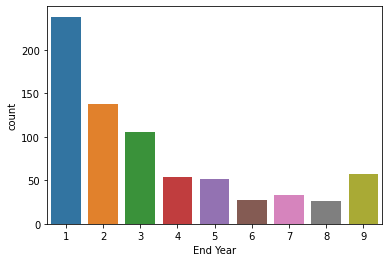

In [119]:
sns.countplot(id_freq_schools['End Year'], label='count')

In [120]:
# Select frequency that a school appears in either the top or bottom percentile of the highly impacted schools
# There should be a default selected. 

select_frequency = 5

# If school code frequency is >= 5 years, then they remain. Unless above variable is updated to a different number.   

for i in id_freq_schools.index:
  if id_freq_schools['End Year'][i] < select_frequency:
    id_freq_schools.drop([i], axis= 0, inplace=True)

freq_school_code = id_freq_schools.index.unique().sort_values()

In [121]:
freq_school_code

Int64Index([  6010,  11022,  11025,  21027,  21150,  26010,  26020,  35011,
             35015,  35020,
            ...
            525014, 537010, 567020, 571002, 571230, 585050, 585125, 585130,
            591061, 591062],
           dtype='int64', name='School Code', length=194)

In [122]:
# This is the detailed schools who are repeatedly in the top/bottom.
# Pulls all of their school data. 

ten_year_impacted = published_ky_df.iloc[0:0,:]

for code in freq_school_code:
  school_ten_year = published_ky_df[published_ky_df['School Code'] == code]
  ten_year_impacted = ten_year_impacted.append(school_ten_year)


In [123]:
ten_year_impacted.sort_values(by=['Money Difference per school'], inplace=True)

In [124]:
ten_year_impacted

,End Year,District Code,District,School Code,School,Proficiency Rate,Classification,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student,5 Classifications
524,2012,275,Jefferson County,275620,Frederick Law Olmsted Academy North,34,Needs Improvement,"10,980.00","-666,200.00",-880.00,"10,097.00",Very Low
8207,2019,275,Jefferson County,275155,Marion C. Moore School,40,Needs Improvement,"14,030.00","-643,000.00",-290.00,"13,743.00",Low
3824,2015,275,Jefferson County,275033,Valley High,50,Needs Improvement,"10,270.00","-634,200.00",-450.00,"9,822.00",Low
5972,2017,275,Jefferson County,275155,Marion C. Moore School,47,Needs Improvement,"12,230.00","-621,500.00",-310.00,"11,921.00",Low
594,2012,275,Jefferson County,275033,Valley High,31,Needs Improvement,"10,290.00","-551,700.00",-600.00,"9,685.00",Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...
8204,2019,275,Jefferson County,275047,Louisville Male High,78,Distinguished,"12,640.00","1,071,800.00",560.00,"13,196.00",Very High
4929,2016,275,Jefferson County,275200,duPont Manual High,91,Distinguished,"11,740.00","1,258,300.00",670.00,"12,410.00",Very High
6024,2017,275,Jefferson County,275200,duPont Manual High,100,Distinguished,"12,380.00","1,265,600.00",670.00,"13,050.00",Very High
7133,2018,275,Jefferson County,275200,duPont Manual High,105,Distinguished,"13,460.00","1,304,000.00",680.00,"14,138.00",Very High
